# Recurrent Neural Network

## Importation librairies

In [16]:
import numpy as np

from tensorflow.keras.utils import normalize, plot_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import models, callbacks

import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

## Data import and display

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

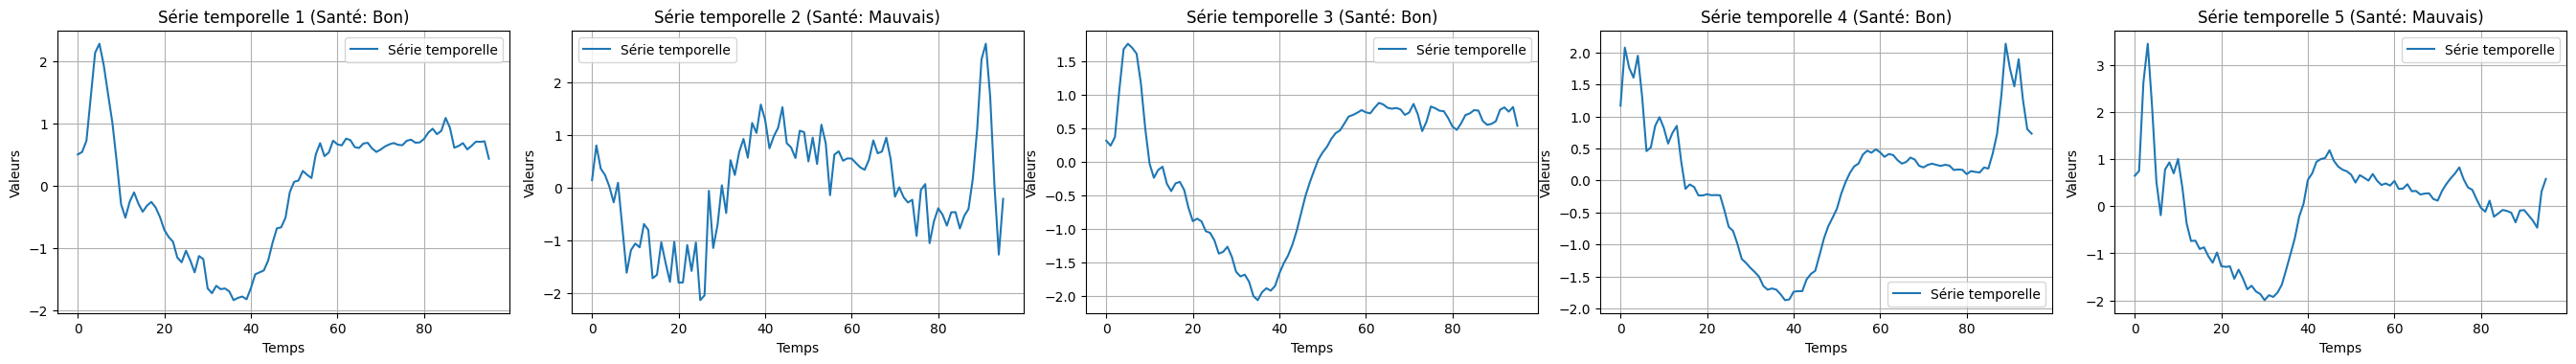

In [17]:
# Data recovery
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Show first time series
print("health:", train_data[0,0])
print(train_data[0,1:])

# Show data dimensions
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Show first 5 time series
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    plage_temps = range(len(serie_temporelle))
    
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Data processing

In [18]:
# Normalizer les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Separation of training and testing data
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Normalize time series between 0 and 1 independently of each other
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

# Display first data
print("health:", y_train[0])
print(X_train[0])
print("Dimensions des données d'entrainnement:", (X_train.shape, y_train.shape))

health: 0.0
[ 0.05150981  0.05562471  0.07411498  0.14660053  0.2192019   0.23404095
  0.19865749  0.15070493  0.10350532  0.03901613 -0.03044895 -0.05272797
 -0.02622859 -0.01099875 -0.02953038 -0.04288682 -0.03274545 -0.02671429
 -0.03594589 -0.05186177 -0.07293548 -0.08453239 -0.09230743 -0.11839274
 -0.12617796 -0.10712148 -0.1233258  -0.14283618 -0.11594667 -0.12105176
 -0.16921172 -0.1771429  -0.16501532 -0.17059991 -0.16935542 -0.17414027
 -0.18864631 -0.18494247 -0.18267915 -0.18725813 -0.16874915 -0.14607979
 -0.14283618 -0.1395757  -0.12313568 -0.09424969 -0.07037348 -0.06852955
 -0.05260412 -0.01043324  0.00656157  0.00847605  0.02437798  0.0179334
  0.01264061  0.05164716  0.0701636   0.04873343  0.05466383  0.07423466
  0.06816803  0.06647679  0.0776721   0.07510896  0.06363272  0.06220474
  0.06955622  0.07069849  0.06143633  0.05567436  0.05969218  0.06470134
  0.06816803  0.07041472  0.06744602  0.06677985  0.07404879  0.07589228
  0.0709444   0.07132904  0.07696012  0.

## Choice of Hyperparameters

In [19]:
# Layers hyperparameters
timesteps = 1
nb_neurons = 8
nb_classes = 1
final_activation = 'sigmoid'

# Compil hyperparameters
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'

# Execution hyperparameters
nb_epochs = 500
mini_batch_size = 32
percentage_of_train_as_validation = 0.2



## Model compilation

In [45]:
# Input
input_shape = (96,1)
input_layer = Input(input_shape)

# Hidden block
lstm_layer = LSTM(units=nb_neurons)(input_layer)

# Output
output_layer = Dense(units=nb_classes, activation=final_activation)(lstm_layer)

model_rnn = models.Model(inputs=input_layer, outputs=output_layer)

(96, 1)


## Model compilation

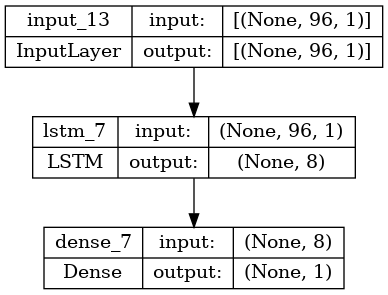

In [46]:
model_rnn.compile(loss=cost_function, optimizer='adam', metrics=['accuracy'])

model_rnn.summary()
plot_model(model_rnn, show_shapes=True)

## Model training

In [47]:
# Specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = callbacks.ModelCheckpoint('best_model_RNN.keras', monitor='val_loss', save_best_only=True)

# Start training
start_training = time.time()
history = model_rnn.fit(X_train, y_train,
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_training = time.time()

## Model evaluation

In [29]:
# Load and evaluate best model
best_model_rnn = models.load_model('best_model_RNN.keras')

train_loss, train_accuracy = best_model_rnn.evaluate(X_train, y_train)

start_evaluate = time.time()
test_loss, test_accuracy = best_model_rnn.evaluate(X_test, y_test)
end_evaluate = time.time()


# Other calcul
y_pred = model_rnn.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_names = ['Positif', 'Négatif']
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

4/4 [==============================] - 0s 3ms/step


## Plot best result


Nombre total de paramètres : 329

Temps d'entraînement : 26.591 secondes.
Temps d'évaluation : 0.068 secondes.

Moyenne de train_accuracy_vals: 87.00%
Moyenne de train_loss_vals: 32.55%

Moyenne de test_accuracy_vals: 75.00%
Moyenne de test_loss_vals: 66.60%

AUC-ROC : 80.38%


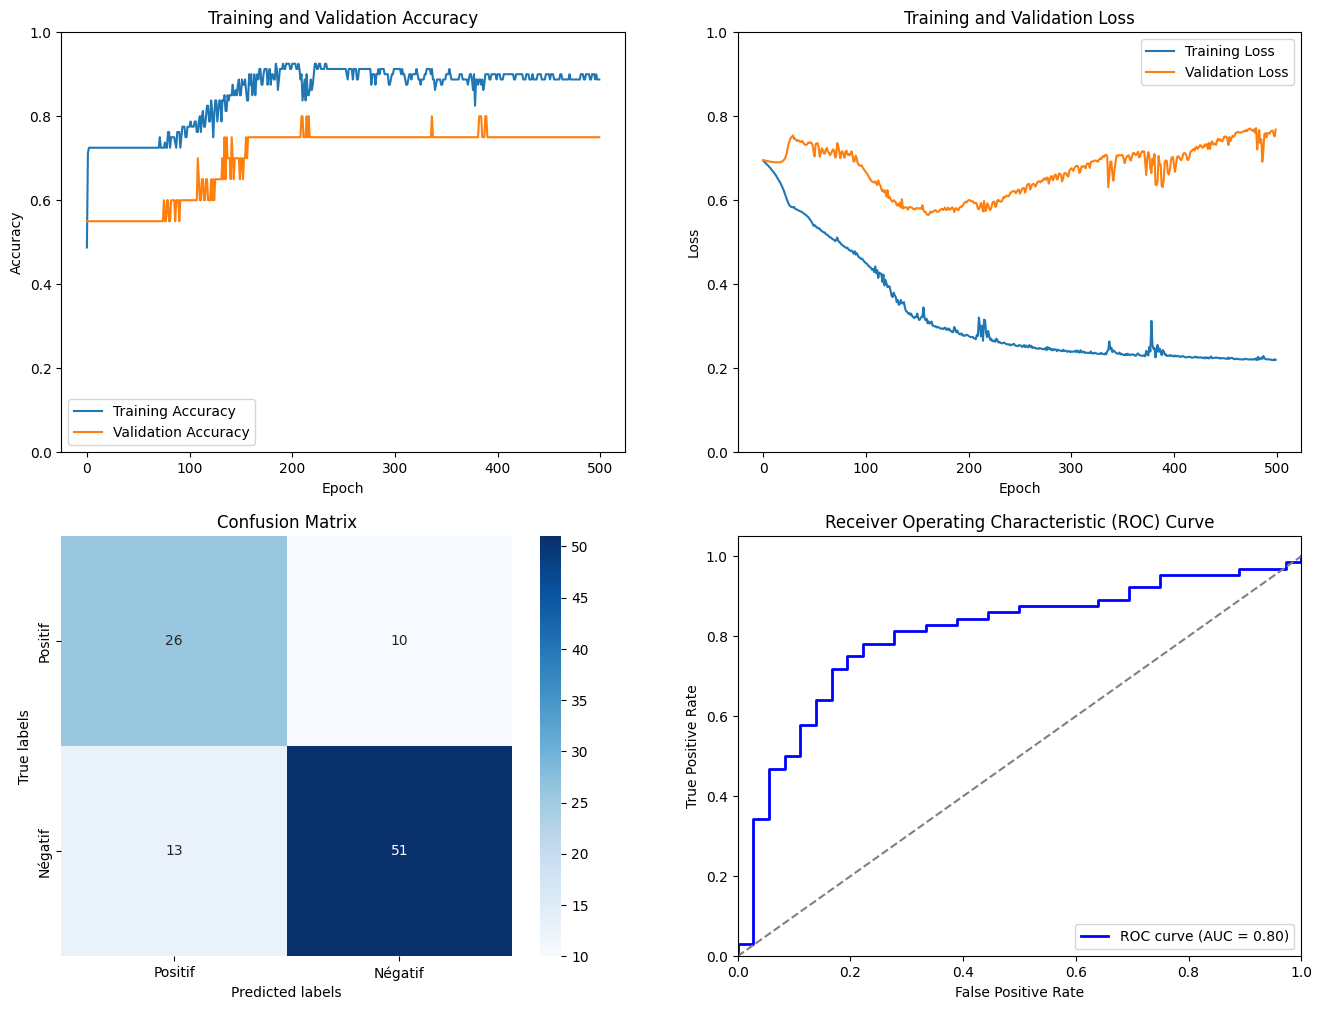

In [49]:
# Result
training_time_seconds = end_training - start_training
evaluate_time_seconds = end_evaluate - start_evaluate
print(f"\nNombre total de paramètres : {best_model_rnn.count_params()}")
print(f"\nTemps d'entraînement : {training_time_seconds:.3f} secondes.")
print(f"Temps d'évaluation : {evaluate_time_seconds:.3f} secondes.")
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss) * 100:.2f}%')
print(f'\nAUC-ROC : {roc_auc * 100:.2f}%')

# Plot 
plt.figure(figsize=(16, 12))
    # Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
    # Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
    # Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
    # ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Cross-validation

In [51]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

test_data[test_data[:, 0] == -1, 0] = 0
X_test, y_test = test_data[:, 1:], test_data[:, 0]
X_test = normalize(X_test, axis=1)

# Hyperparameters
timesteps = 1
nb_neurons = 8
nb_classes = 1
final_activation = 'sigmoid'
optimizer_algo = 'adam'
cost_function = 'binary_crossentropy'
nb_epochs = 500
mini_batch_size = 32
percentage_of_train_as_validation = 0.2

num_splits = 5
test_accuracy_vals = []
test_loss_vals = []
train_accuracy_vals = []
train_loss_vals = []

for i in range(num_splits) :
    train_data_suffled = train_data
    np.random.shuffle(train_data_suffled)
    train_data_suffled[train_data_suffled[:, 0] == -1, 0] = 0
    X_train, y_train = train_data_suffled[:, 1:], train_data_suffled[:, 0]
    X_trai = normalize(X_train, axis=1)

    # build and compil model# Input
    input_shape = (96,1)
    input_layer = Input(input_shape)
    lstm_layer = LSTM(units=nb_neurons)(input_layer)
    output_layer = Dense(units=nb_classes, activation=final_activation)(lstm_layer)
    model_rnn = models.Model(inputs=input_layer, outputs=output_layer)
    model_rnn.compile(loss=cost_function, optimizer='adam', metrics=['accuracy'])

    model_checkpoint = callbacks.ModelCheckpoint('best_model_RNN.keras', monitor='val_loss', save_best_only=True)

    history = model_rnn.fit(X_train, y_train,
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_split=percentage_of_train_as_validation,
                        verbose=False,
                        callbacks=[model_checkpoint])

    # evaluate best model
    best_model_rnn = models.load_model('best_model_RNN.keras')
    train_loss, train_accuracy = best_model_rnn.evaluate(X_train, y_train)
    test_loss, test_accuracy = best_model_rnn.evaluate(X_test, y_test)

    test_accuracy_vals.append(test_accuracy)
    test_loss_vals.append(test_loss)
    train_accuracy_vals.append(train_accuracy)
    train_loss_vals.append(train_loss)

# Display result

# Calcul de la précision pour les données
print("\nNombre d'essais :", num_splits)
print(f'\nMoyenne de train_accuracy_vals: {np.mean(train_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de train_loss_vals: {np.mean(train_loss_vals) * 100:.2f}%')
print(f'\nMoyenne de test_accuracy_vals: {np.mean(test_accuracy_vals) * 100:.2f}%')
print(f'Moyenne de test_loss_vals: {np.mean(test_loss_vals) * 100:.2f}%')
print(f'\tLa variance associée de l\'accuracy: {np.var(test_accuracy_vals):.6f}')
print(f'\tLa variance associée de la loss: {np.var(test_loss_vals):.6f}')

4/4 [==============================] - 0s 4ms/step - loss: 1.4324 - accuracy: 0.3000

Nombre d'essais : 5

Moyenne de train_accuracy_vals: 87.00%
Moyenne de train_loss_vals: 29.50%

Moyenne de test_accuracy_vals: 37.60%
Moyenne de test_loss_vals: 107.55%
	La variance associée de l'accuracy: 0.032224
	La variance associée de la loss: 0.146265
